In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from share import *
from utils import *
from hypOpt import *
from plot import *
import os
import psutil
import platform
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [2]:
seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

# 📦 Version Info
print("📦 Versions:")
print(f"Python: {platform.python_version()}")
print(f"PyTorch: {torch.__version__}")
print(f"GPyTorch: {gpytorch.__version__}")

# 🚀 GPU Info
print("\n🚀 GPU Info:")
if torch.cuda.is_available():
    print(f"CUDA available: True")
    for i in range(torch.cuda.device_count()):
        print(f"  [{i}] {torch.cuda.get_device_name(i)}")
else:
    print("CUDA available: False")

# 🧮 CPU Info
print("\n🧮 CPU Info:")
print(f"Processor: {platform.processor()}")
print(f"Cores (physical): {psutil.cpu_count(logical=False)}")
print(f"Cores (logical): {psutil.cpu_count(logical=True)}")

# 🧠 RAM Info
print("\n🧠 RAM Info:")
vmem = psutil.virtual_memory()
print(f"Total: {vmem.total / (1024**3):.2f} GB")
print(f"Available: {vmem.available / (1024**3):.2f} GB")

# ⚙️ CUDA Toolkit Version (if available)
print("\n⚙️ CUDA Toolkit Version:")
try:
    output = os.popen("nvcc --version").read()
    print(output if output else "nvcc not found")
except:
    print("Could not retrieve CUDA version")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

📦 Versions:
Python: 3.10.18
PyTorch: 2.5.1
GPyTorch: 1.14

🚀 GPU Info:
CUDA available: False

🧮 CPU Info:
Processor: Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
Cores (physical): 12
Cores (logical): 20

🧠 RAM Info:
Total: 15.77 GB
Available: 5.90 GB

⚙️ CUDA Toolkit Version:
nvcc not found
Using device: cpu


# 5.1 Evaluation of hyperparameter optimization

### 1. Set configuration

In [3]:
config = {
    "M"    : 10,               # Number of agents  
    "Ni"   : 4,               # Number of neighbors
    "q"    : 2**40,           # Modulus
    "Lw"   : 1/40,            # Scale factor
    "Lz"   : 1/2**20,         # Scale factor
    "Thyp" : 30,              # Optimization step for hyperparameter optimization
    "eta"  : 0.1,             # Learning rate
    "decay": 0.99,            # Decay rate
    "T"    : 20               # Optimization step for main Protocol
}

### 2. Network topology


##### a) Graph generation

In [4]:
import networkx as nx

# --- Generate undirected, connected Ni-regular graph with M agents 
### Every agent has Ni number of neighbors
assert config["Ni"] < config["M"] and config["Ni"] >= 1 and (config["M"] * config["Ni"]) % 2 == 0, "Invalid Ni-regular graph"

connected = False
while not connected:
    G = nx.random_regular_graph(d=config["Ni"], n=config["M"]) 
    connected = nx.is_connected(G)

### (Optional) Visualize the graph
# nx.draw(G, with_labels=True)
# plt.show()

##### b) Define Metropolis weight 

In [5]:
# --- Define Metropolis weights
C = 2
W = np.zeros((config["M"], config["M"]))
for i in range(config["M"]):
    d_i = G.degree[i]
    for j in G.neighbors(i):
        d_j = G.degree[j]
        W[i, j] = 1 / (C * (1 + max(d_i, d_j)))
    W[i, i] = 1 - np.sum(W[i])  # self-weight

config["Wbar"] = W/config["Lw"]

### 3. Data preprocessing

##### a) SARCOS dataset

In [6]:
# Training data: 44,484
# Test data: 4,449
# 21 inputs
# 7 outputs

from scipy.io import loadmat

# --- Load data
train_data = loadmat('data/sarcos_inv.mat')
full_train = train_data['sarcos_inv']  # shape: (44484, 28)
test_data = loadmat('data/sarcos_inv_test.mat')
full_test = test_data['sarcos_inv_test']  # shape: (4449, 28)

# --- Split into inputs and outputs
sarcos_X_train = full_train[:, :21]
sarcos_Y_train = full_train[:, 21:]

sarcos_X_test = full_test[:, :21]
sarcos_Y_test = full_test[:, 21:]

print("Train x size:", sarcos_X_train.shape)
print("Test x size:", sarcos_X_test.shape)
print("Train y size:", sarcos_Y_train.shape)
print("Test y size:", sarcos_Y_test.shape)

# --- Output dimension
config["k"] = sarcos_Y_train.shape[1]

# --- Convert to torch tensors
sarcos_X_train_t = torch.tensor(sarcos_X_train, dtype=torch.float32)
sarcos_Y_train_t = torch.tensor(sarcos_Y_train, dtype=torch.float32)
sarcos_X_test_t = torch.tensor(sarcos_X_test, dtype=torch.float32)
sarcos_Y_test_t = torch.tensor(sarcos_Y_test, dtype=torch.float32)

# --- Shuffle training data
sarcos_perm = torch.randperm(sarcos_X_train_t.size(0))
sarcos_X_train_shuffled = sarcos_X_train_t[sarcos_perm]
sarcos_Y_train_shuffled = sarcos_Y_train_t[sarcos_perm]

# --- Split into M parts for agents
sarcos_X_parts = [part.to(device) for part in torch.tensor_split(sarcos_X_train_shuffled, config["M"])]
sarcos_Y_parts = [part.to(device) for part in torch.tensor_split(sarcos_Y_train_shuffled, config["M"])]

Train x size: (44484, 21)
Test x size: (4449, 21)
Train y size: (44484, 7)
Test y size: (4449, 7)


##### b) Diabetes dataset

In [7]:
# --- Load data
diabetes = load_diabetes()
diab_X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
diab_Y = pd.Series(diabetes.target, name='target')

# --- Split into train/test points (80/20)
diab_X_train, diab_X_test, diab_Y_train, diab_Y_test = train_test_split(
    diab_X, diab_Y, test_size=0.2, random_state=42
)

# --- Number of test points
diab_ntest = diab_X_test.shape[0]  

print("Train x size:", diab_X_train.shape)
print("Test x size:", diab_X_test.shape)
print("Train y size:", diab_Y_train.shape)
print("Test y size:", diab_Y_test.shape)

# --- Convert to torch tensors 
diab_X_train_t = torch.tensor(diab_X_train.values, dtype=torch.float32)
diab_Y_train_t = torch.tensor(diab_Y_train.values, dtype=torch.float32)
diab_X_test_t = torch.tensor(diab_X_test.values, dtype=torch.float32)
diab_Y_test_t = torch.tensor(diab_Y_test.values, dtype=torch.float32)

# --- Shuffle training data
diab_perm = torch.randperm(diab_X_train_t.size(0))
diab_X_train_shuffled = diab_X_train_t[diab_perm]
diab_Y_train_shuffled = diab_Y_train_t[diab_perm]

# --- Split into M parts for agents
diab_X_parts = [x.to(device) for x in torch.tensor_split(diab_X_train_shuffled, config["M"])]
diab_Y_parts = [y.to(device) for y in torch.tensor_split(diab_Y_train_shuffled, config["M"])]

# --- Make y_parts 2D for GP compatibility
diab_Y_parts = [y.unsqueeze(-1) for y in diab_Y_parts]


Train x size: (353, 10)
Test x size: (89, 10)
Train y size: (353,)
Test y size: (89,)


### 4. Hyperparameter optimization

##### a) SARCOS dataset

In [8]:
# --- Hyperparameter optimization
### Comment this section out to load pre-trained hyperparameter
sarcos_scales = [10.0, 10.0, 10.0]
sarcos_models_all, sarcos_likelihoods_all, sarcos_history_all, sarcos_loss_sum_all = hyperparameter_optimization(sarcos_X_parts, sarcos_Y_parts, G, config, sarcos_scales, device)

for i in range(config["M"]):
    for d in range(config["k"]):
        sarcos_models_all[i][d] = sarcos_models_all[i][d].to(device)
        sarcos_likelihoods_all[i][d] = sarcos_likelihoods_all[i][d].to(device)


c:\Users\user\OneDrive\암호\2025\2025 AAAI Distributed GPR\Privacy-preservng-dGPR\hypOpt.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(consensus_result[i, :], dtype=torch.float32, device=device)


KeyboardInterrupt: 

##### b) Diabetes dataset

In [ ]:
# --- Hyperparameter optimization
### Comment this section out to load pre-trained hyperparameter
diab_scales = [10.0, 10.0, 20.0]
diab_models, diab_likelihoods, diab_history, diab_loss_sum, diab_elapsed = hyperparameter_optimization_1D(diab_X_parts, diab_Y_parts, G, config, diab_scales, device)
for i in range(config["M"]):
    diab_models[i] = diab_models[i].to(device)
    diab_likelihoods[i] = diab_likelihoods[i].to(device)


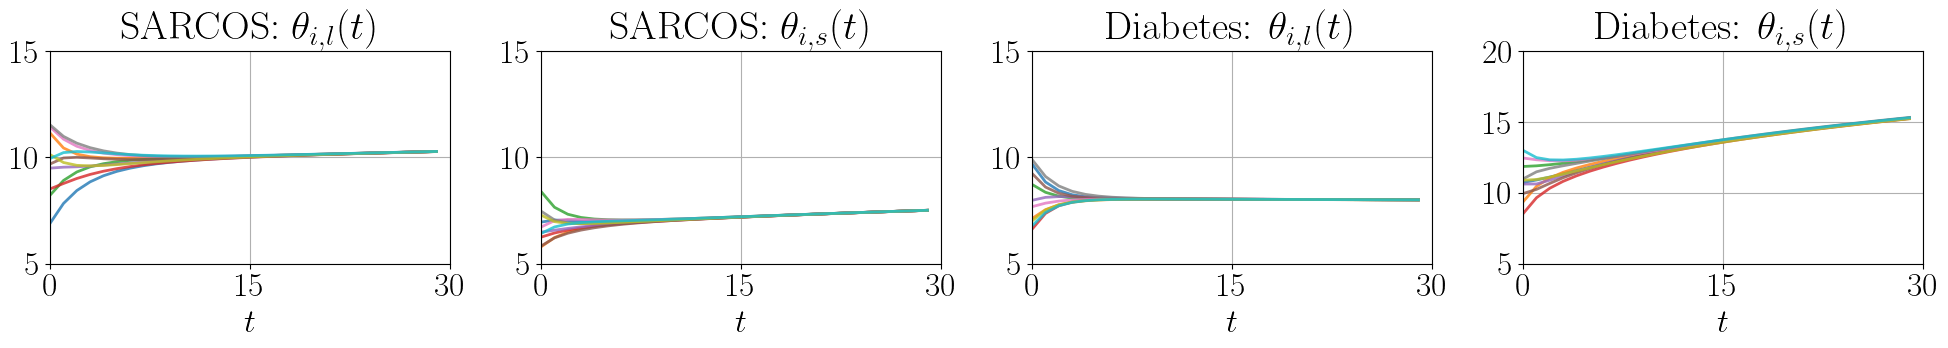

In [ ]:
# --- change sarcos_history_all[0] to sarcos_history_all[i] to see the result for i-th output dimension
plot_hyperparameter(sarcos_history_all[0], diab_history, config)

# 5.2 Accuracy analysis: Iterations and scale factor


### 1. Run standard distributed GPR

##### a) SARCOS

In [ ]:
sarcos_test_samples = 10 # desired number of test points (less than or equal to 4449)

# Select the test_samples
sarcos_X_test_red = sarcos_X_test[:sarcos_test_samples, :]
sarcos_Y_test_red = sarcos_Y_test[:sarcos_test_samples, :]

# Convert to torch tensors 
sarcos_X_test_t_red = torch.tensor(sarcos_X_test_red, dtype=torch.float32)
sarcos_Y_test_t_red = torch.tensor(sarcos_Y_test_red, dtype=torch.float32)

# sarcos_means[i][j]: predicted mean from agent i for output dimension j
# sarcos_variances[i][j]: predicted variance from agent i for output dimension j
sarcos_means     = [[None for _ in range(config["k"])] for _ in range(config["M"])]
sarcos_variances = [[None for _ in range(config["k"])] for _ in range(config["M"])]

num_repeats = 20
times = []

for _ in range(num_repeats):
    start_time = time.time()

    for i in range(config["M"]):  # iterate over agents
        for j in range(config["k"]):  # iterate over output dimensions
            model = sarcos_models_all[i][j]
            likelihood = sarcos_likelihoods_all[i][j]
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                pred = likelihood(model(sarcos_X_test_t_red))
                sarcos_means[i][j] = pred.mean       # shape: (N_test,)
                sarcos_variances[i][j] = pred.variance  # shape: (N_test,)

    end_time = time.time()
    times.append(end_time - start_time)

mean_time = np.mean(times)
std_time = np.std(times)

print(f"Average time over {num_repeats} runs for local prediction: {mean_time:.6f} ± {std_time:.6f} seconds")

Average time over 20 runs for local prediction: 9.418552 ± 15.439635 seconds


In [ ]:
# --- Compute POE mean and variances
sarcos_poe_means = torch.zeros(sarcos_test_samples, config["k"], device=device)
sarcos_poe_vars  = torch.zeros(sarcos_test_samples, config["k"], device=device)

num_repeats = 20
times = []

for _ in range(num_repeats):
    start_time = time.time()

    for j in range(config["k"]):  # loop over output dimensions
        all_means = []  # shape: (M, N_test)
        all_vars  = []  # shape: (M, N_test)

        for i in range(config["M"]):  # loop over agents
            m = sarcos_means[i][j]     # tensor of shape (N_test,)
            v = sarcos_variances[i][j] # tensor of shape (N_test,)
            all_means.append(m.unsqueeze(0))  # shape (1, N_test)
            all_vars.append(v.unsqueeze(0))

        all_means = torch.cat(all_means, dim=0)  # shape: (M, N_test)
        all_vars = torch.cat(all_vars, dim=0)    # shape: (M, N_test)

        inv_vars = 1.0 / all_vars
        poe_vars_j = 1.0 / inv_vars.sum(dim=0)
        poe_means_j = poe_vars_j * (inv_vars * all_means).sum(dim=0)

        sarcos_poe_means[:, j] = poe_means_j
        sarcos_poe_vars[:, j]  = poe_vars_j

    end_time = time.time()
    times.append(end_time - start_time)

mean_time = np.mean(times)
std_time = np.std(times)

print(f"Average time over {num_repeats} runs for PoE aggregation: {mean_time:.6f} ± {std_time:.6f} seconds")

Average time over 20 runs for PoE aggregation: 0.002046 ± 0.001154 seconds


##### b) Diabetes

In [ ]:
diab_means = [None for _ in range(config["M"])]
diab_vars  = [None for _ in range(config["M"])]

diab_X_test_t = diab_X_test_t.to(device)

num_repeats = 20
times = []

for _ in range(num_repeats):
    start_time = time.time()

    for i in range(config["M"]):
        model = diab_models[i]
        likelihood = diab_likelihoods[i]
        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = likelihood(model(diab_X_test_t))
            diab_means[i] = pred.mean       # shape: (N_test,)
            diab_vars[i]  = pred.variance   # shape: (N_test,)

    end_time = time.time()
    times.append(end_time - start_time)

mean_time = np.mean(times)
std_time = np.std(times)

print(f"Average time over {num_repeats} runs for local prediction: {mean_time:.6f} ± {std_time:.6f} seconds")

Average time over 20 runs for local prediction: 0.022727 ± 0.015077 seconds


In [ ]:
# --- Compute PoE mean and variances for Diab dataset
diab_poe_means = torch.zeros_like(diab_means[0], device=device)  # shape: (N_test,)
diab_poe_vars  = torch.zeros_like(diab_vars[0], device=device)   # shape: (N_test,)

diab_means_tensor = torch.stack(diab_means, dim=0).to(device)  # shape: (M, N_test)
diab_vars_tensor  = torch.stack(diab_vars, dim=0).to(device)   # shape: (M, N_test)

num_repeats = 20
times = []

for _ in range(num_repeats):
    start_time = time.time()

    all_means = diab_means_tensor  # shape: (M, N_test)
    all_vars  = diab_vars_tensor   # shape: (M, N_test)

    inv_vars = 1.0 / all_vars
    poe_vars = 1.0 / inv_vars.sum(dim=0)                # shape: (N_test,)
    poe_means = poe_vars * (inv_vars * all_means).sum(dim=0)  # shape: (N_test,)

    diab_poe_means[:] = poe_means
    diab_poe_vars[:]  = poe_vars

    end_time = time.time()
    times.append(end_time - start_time)

mean_time = np.mean(times)
std_time = np.std(times)

print(f"Average time over {num_repeats} runs for PoE aggregation: {mean_time:.6f} ± {std_time:.6f} seconds")

Average time over 20 runs for PoE aggregation: 0.000133 ± 0.000335 seconds


### 2. Run main protocol by varying scale factor

### a) SARCOS


In [ ]:
# Lz_values = [10000]
Lz_values = [1,100,10000]
num_Lz = len(Lz_values)
num_repeats = 20
times = []

for repeat in range(num_repeats):
    print(f"\n=== Run {repeat + 1}/{num_repeats} ===")
    start_time = time.time()

    # Allocate storage per run (could also preallocate once outside if reused)
    sarcos_pppoe_means = torch.zeros((num_Lz, config["T"]+1, sarcos_test_samples, config["k"], config["M"]), device=device)
    sarcos_pppoe_vars  = torch.zeros((num_Lz, config["T"]+1, sarcos_test_samples, config["k"], config["M"]), device=device)

    for lz_idx, Lz in enumerate(Lz_values):
        print(f"Running consensus with Lz = 1/{Lz}")
        config["Lz"] = 1.0 / Lz

        all_means = torch.stack([
            torch.stack([sarcos_means[m][j].to(device) for j in range(config["k"])])
            for m in range(config["M"])
        ]).permute(0, 2, 1) 

        all_vars = torch.stack([
            torch.stack([sarcos_variances[m][j].to(device) for j in range(config["k"])])
            for m in range(config["M"])
        ]).permute(0, 2, 1) 

        weighted_means = all_means / all_vars
        precisions = 1.0 / all_vars
        weighted_means *= config["M"]
        precisions *= config["M"]
        combined = torch.stack([weighted_means, precisions], axis=-1)
        z_combined = combined.reshape(config["M"], -1).cpu().numpy() 

        consensus_history = privacy_preserving_avg_consensus(z_combined, G, config, config["T"]+1, device)

        for t in range(config["T"]+1):
            step_t = consensus_history[t]
            step_t_reshaped = step_t.reshape(config["M"], sarcos_test_samples, config["k"], 2)

            means = torch.tensor(step_t_reshaped[:, :, :, 0], device=device) / torch.tensor(step_t_reshaped[:, :, :, 1], device=device)
            vars_ = 1.0 / torch.tensor(step_t_reshaped[:, :, :, 1], device=device)

            sarcos_pppoe_means[lz_idx, t, :, :, :] = means.permute(1, 2, 0)
            sarcos_pppoe_vars[lz_idx, t, :, :, :]  = vars_.permute(1, 2, 0)

    end_time = time.time()
    elapsed = end_time - start_time
    times.append(elapsed)
    print(f"Run {repeat + 1} time: {elapsed:.4f} seconds")

# Final summary
mean_time = np.mean(times)
std_time = np.std(times)
print(f"\nAverage time over {num_repeats} runs for proposed protocol: {mean_time:.4f} ± {std_time:.4f} seconds")


sarcos_rmse_means = torch.zeros((num_Lz, config["T"]+1), device=device)
sarcos_rmse_vars = torch.zeros((num_Lz, config["T"]+1), device=device)

for lz_idx in range(num_Lz):
    for t in range(config["T"]+1):
        rmse_means = torch.zeros(config["M"], device=device)
        rmse_vars  = torch.zeros(config["M"], device=device)

        for m in range(config["M"]):
            pred_mean = sarcos_pppoe_means[lz_idx, t, :, :, m] 
            pred_var  = sarcos_pppoe_vars[lz_idx, t, :, :, m]   
            
            diff_mean = pred_mean - sarcos_poe_means.to(device)
            diff_var  = pred_var  - sarcos_poe_vars.to(device)
            
            rmse_mean = torch.sqrt(torch.mean(diff_mean ** 2))
            rmse_var  = torch.sqrt(torch.mean(diff_var ** 2))

            rmse_means[m] = rmse_mean
            rmse_vars[m]  = rmse_var
            
        sarcos_rmse_means[lz_idx, t] = torch.mean(rmse_means)
        sarcos_rmse_vars[lz_idx, t] = torch.mean(rmse_vars)

for lz_idx in range(num_Lz):
    print(f"Lz index {lz_idx}: RMSE Mean at last iteration = {sarcos_rmse_means[lz_idx, config['T']]:.6f}, "
          f"RMSE Variance at last iteration = {sarcos_rmse_vars[lz_idx, config['T']]:.6f}")




=== Run 1/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000


C:\Users\user\AppData\Local\Temp\ipykernel_26888\3367899925.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(step_t_reshaped[:, :, :, 0], device=device) / torch.tensor(step_t_reshaped[:, :, :, 1], device=device)
C:\Users\user\AppData\Local\Temp\ipykernel_26888\3367899925.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vars_ = 1.0 / torch.tensor(step_t_reshaped[:, :, :, 1], device=device)


Run 1 time: 0.2971 seconds

=== Run 2/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 2 time: 0.2908 seconds

=== Run 3/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 3 time: 0.2978 seconds

=== Run 4/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 4 time: 0.3041 seconds

=== Run 5/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 5 time: 0.2977 seconds

=== Run 6/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 6 time: 0.2985 seconds

=== Run 7/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 7 time: 0.3018 seconds

=== Run 8/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running

##### b) Diabetes

In [ ]:

# Lz_values = [10000]
Lz_values = [1,100,10000]
num_Lz = len(Lz_values)
num_repeats = 20
times = []

diab_test_samples = diab_X_test.shape[0]

for repeat in range(num_repeats):
    print(f"\n=== Run {repeat + 1}/{num_repeats} ===")
    start_time = time.time()

    # Allocate storage per run
    diab_pppoe_means = torch.zeros((num_Lz, config["T"]+1, diab_test_samples, config["M"]), device=device)
    diab_pppoe_vars  = torch.zeros((num_Lz, config["T"]+1, diab_test_samples, config["M"]), device=device)

    for lz_idx, Lz in enumerate(Lz_values):
        print(f"Running consensus with Lz = 1/{Lz}")
        config["Lz"] = 1.0 / Lz

        means_tensor = torch.stack([diab_means[m].to(device) for m in range(config["M"])])  
        vars_tensor  = torch.stack([diab_vars[m].to(device) for m in range(config["M"])])  

        weighted_means = config["M"] * (means_tensor / vars_tensor)  
        precisions = config["M"] * (1.0 / vars_tensor)                

        combined = torch.stack([weighted_means, precisions], axis=-1) 
        z_combined = combined.reshape(config["M"], -1).cpu().numpy() 

        consensus_history = privacy_preserving_avg_consensus(z_combined, G, config, config["T"]+1, device)

        for t in range(config["T"]+1):
            step_t = consensus_history[t]  # shape: (M, ntest*2)
            step_t_reshaped = step_t.reshape(config["M"], diab_test_samples, 2)

            means = torch.tensor(step_t_reshaped[:, :, 0],device=device) / torch.tensor(step_t_reshaped[:, :, 1],device=device) 
            vars_  = 1.0 / torch.tensor(step_t_reshaped[:, :, 1],device=device)                     

            diab_pppoe_means[lz_idx, t] = means.permute(1, 0)
            diab_pppoe_vars[lz_idx, t]  = vars_.permute(1, 0)

    end_time = time.time()
    elapsed = end_time - start_time
    times.append(elapsed)
    print(f"Run {repeat + 1} time: {elapsed:.4f} seconds")

# Summary statistics
mean_time = np.mean(times)
std_time = np.std(times)
print(f"\nAverage time over {num_repeats} runs for proposed protocol: {mean_time:.4f} ± {std_time:.4f} seconds")

diab_rmse_means = torch.zeros((num_Lz, config["T"]+1), device=device)
diab_rmse_vars = torch.zeros((num_Lz, config["T"]+1), device=device)

for lz_idx in range(num_Lz):
    for t in range(config["T"]+1):
        rmse_means = torch.zeros(config["M"], device=device)
        rmse_vars = torch.zeros(config["M"], device=device)

        for m in range(config["M"]):
            pred_mean = diab_pppoe_means[lz_idx, t, :, m] 
            pred_var  = diab_pppoe_vars[lz_idx, t, :, m]   
            
            diff_mean = pred_mean - diab_poe_means.to(device)
            diff_var = pred_var - diab_poe_vars.to(device)
            
            rmse_mean = torch.sqrt(torch.mean(diff_mean ** 2))
            rmse_var  = torch.sqrt(torch.mean(diff_var ** 2))

            rmse_means[m] = rmse_mean
            rmse_vars[m]  = rmse_var
        diab_rmse_means[lz_idx, t] = torch.mean(rmse_means)
        diab_rmse_vars[lz_idx, t] = torch.mean(rmse_vars)

for lz_idx in range(num_Lz):
    print(f"Lz index {lz_idx}: RMSE Mean at last iteration = {diab_rmse_means[lz_idx, config['T']]:.6f}, "
          f"RMSE Variance at last iteration = {diab_rmse_vars[lz_idx, config['T']]:.6f}")


=== Run 1/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100


C:\Users\user\AppData\Local\Temp\ipykernel_26888\2426945041.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(step_t_reshaped[:, :, 0],device=device) / torch.tensor(step_t_reshaped[:, :, 1],device=device)
C:\Users\user\AppData\Local\Temp\ipykernel_26888\2426945041.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vars_  = 1.0 / torch.tensor(step_t_reshaped[:, :, 1],device=device)


Running consensus with Lz = 1/10000
Run 1 time: 0.3080 seconds

=== Run 2/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 2 time: 0.3012 seconds

=== Run 3/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 3 time: 0.2944 seconds

=== Run 4/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 4 time: 0.3012 seconds

=== Run 5/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 5 time: 0.2943 seconds

=== Run 6/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 6 time: 0.3100 seconds

=== Run 7/20 ===
Running consensus with Lz = 1/1
Running consensus with Lz = 1/100
Running consensus with Lz = 1/10000
Run 7 time: 0.3115 seconds

=== Run 8/20 ===
Running consensus with Lz = 1/1
Runni

c:\Users\user\OneDrive\암호\2025\2025 AAAI Distributed GPR\Privacy-preservng-dGPR\plot.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


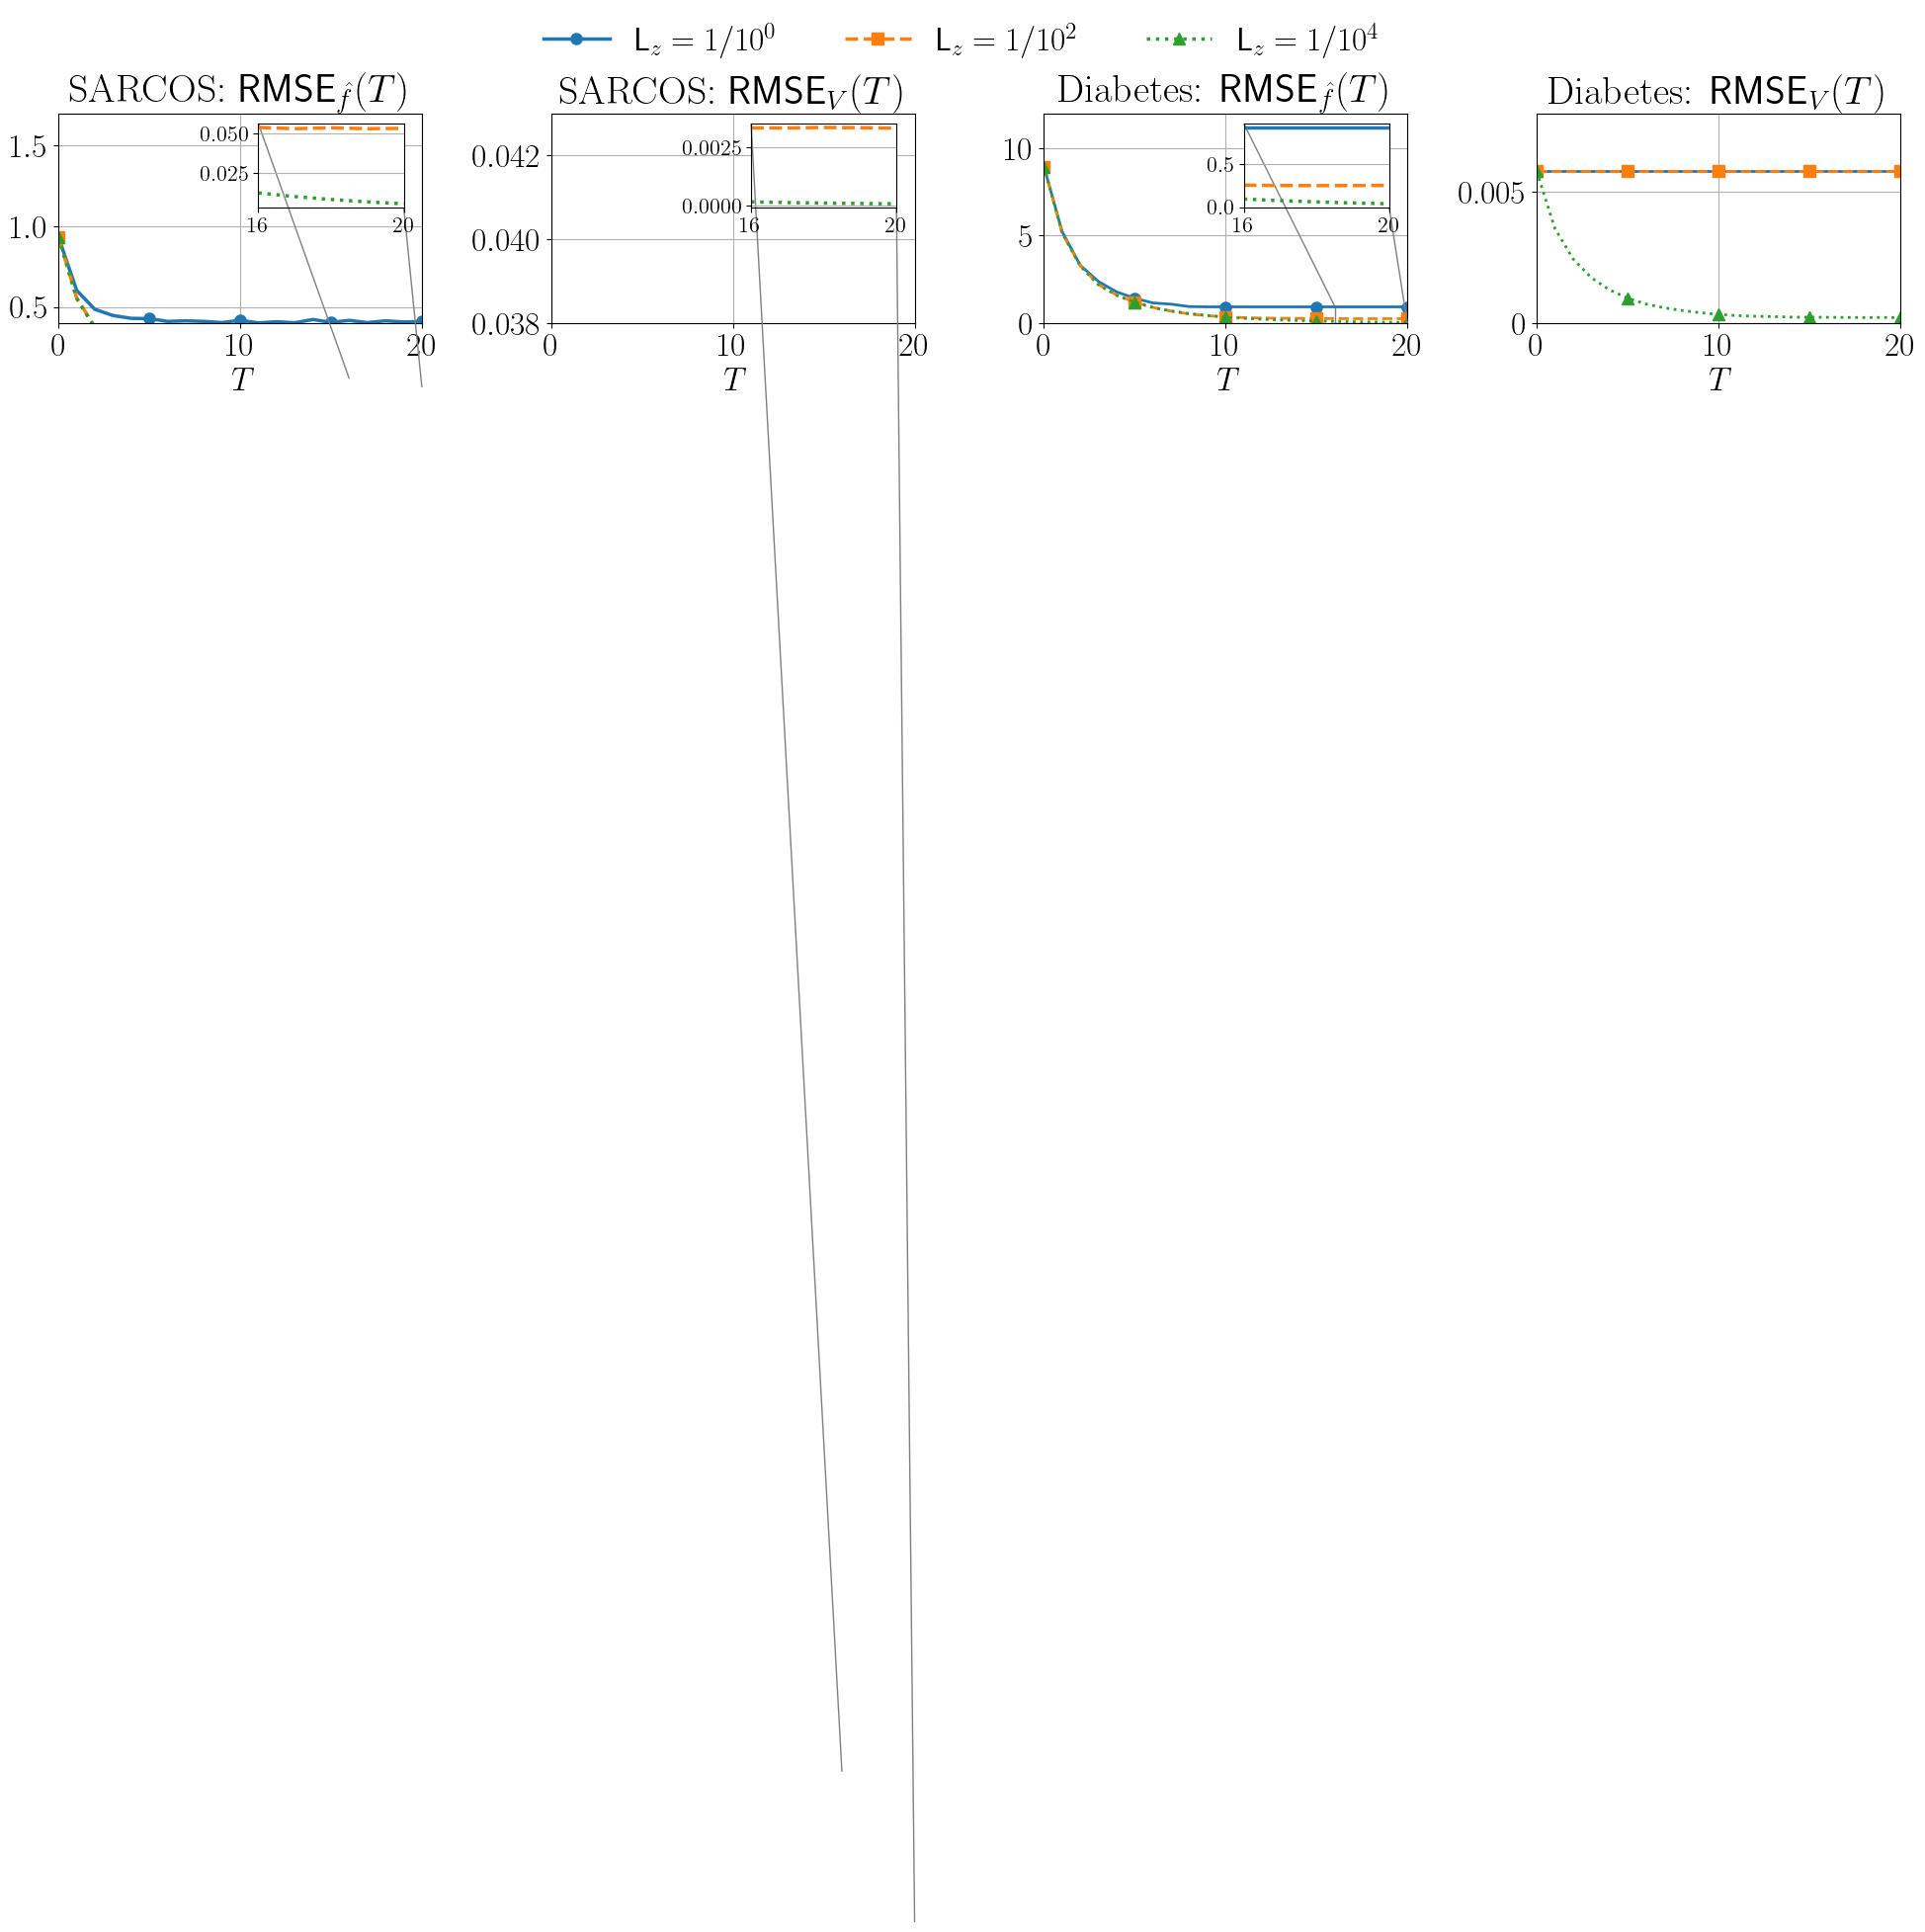

In [ ]:
plot_accuracy(sarcos_rmse_means, sarcos_rmse_vars, diab_rmse_means, diab_rmse_vars, config, Lz_values)